In [1]:
import os
os.chdir("../")

In [139]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [147]:
# load mat data
from scipy.io import loadmat
from scipy import signal
data = loadmat("./data/high_rise_building_wind.mat")
wind_data = data["windsp_1h"].flatten()
fs = 1
decimation_factor = int(100 / fs)
wind_data = signal.decimate(wind_data, decimation_factor, ftype='fir',)

wind_data.shape

(3600,)

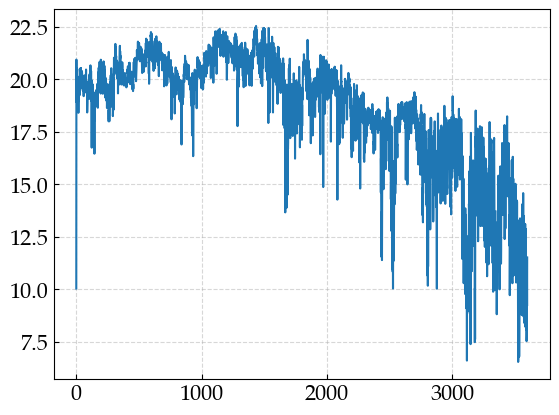

In [148]:
plt.plot(wind_data)

In [157]:
frequencies, psd = signal.welch(wind_data-np.mean(wind_data), fs=fs,
                                window='hamming', 
                                scaling='density', nperseg=1024)
frequencies = frequencies[1:]  # 去掉直流分量
psd = psd[1:]
u_bar = np.mean(wind_data)
u10 = u_bar * (10 / 450) ** 0.30
z = 632
z0 = 1.0
H_ = 200
K = 0.4
zd = H_ - z0 / K
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies

In [158]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type="kaimal-nd")
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=3600,
    M=3600,
    N=1800,
    dt=1/fs,
    U_d=u10,
    alpha_0=0.30,
    w_up=fs/2,
)

n = 50
Z = 632
position = np.zeros((n, 3))
position[:, 2] = np.linspace(200, Z, n)
position[:, 0] = 0
position[:, 1] = 0
wind_speeds = u10 * (jnp.minimum(position[:, 2], 450) / 10) ** 0.30
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[-1], fs=fs, window='hamming', 
                                   scaling='density', nperseg=1024)

In [159]:
frequencies_sim

array([0.        , 0.00097656, 0.00195312, 0.00292969, 0.00390625,
       0.00488281, 0.00585938, 0.00683594, 0.0078125 , 0.00878906,
       0.00976562, 0.01074219, 0.01171875, 0.01269531, 0.01367188,
       0.01464844, 0.015625  , 0.01660156, 0.01757812, 0.01855469,
       0.01953125, 0.02050781, 0.02148438, 0.02246094, 0.0234375 ,
       0.02441406, 0.02539062, 0.02636719, 0.02734375, 0.02832031,
       0.02929688, 0.03027344, 0.03125   , 0.03222656, 0.03320312,
       0.03417969, 0.03515625, 0.03613281, 0.03710938, 0.03808594,
       0.0390625 , 0.04003906, 0.04101562, 0.04199219, 0.04296875,
       0.04394531, 0.04492188, 0.04589844, 0.046875  , 0.04785156,
       0.04882812, 0.04980469, 0.05078125, 0.05175781, 0.05273438,
       0.05371094, 0.0546875 , 0.05566406, 0.05664062, 0.05761719,
       0.05859375, 0.05957031, 0.06054688, 0.06152344, 0.0625    ,
       0.06347656, 0.06445312, 0.06542969, 0.06640625, 0.06738281,
       0.06835938, 0.06933594, 0.0703125 , 0.07128906, 0.07226

[Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (m$^2$/s)')]

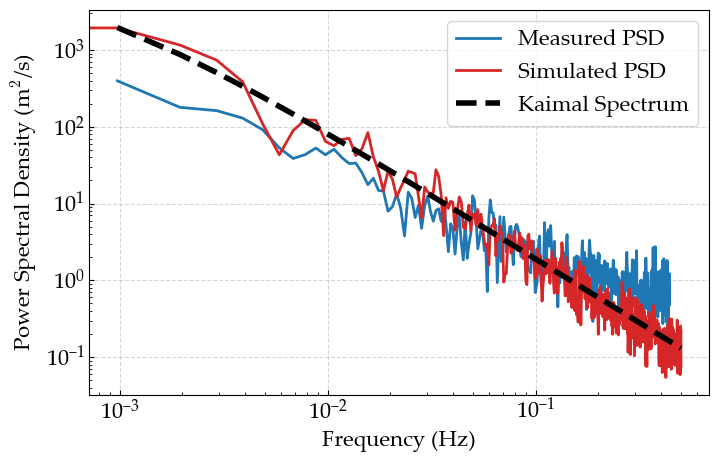

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies[:-60], psd[:-60], label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
# fig.savefig("./img/high_rise_building_wind_spectrum.pdf", bbox_inches="tight")
# fig.savefig("./img/high_rise_building_wind_spectrum.png", bbox_inches="tight", dpi=300)